# 🤖 Artie 프로젝트 모델 선정 벤치마크 (v4.2 - Reality Check)

이 노트북은 실제 프로젝트(`LLM_With_Arduino_FN.py`) 환경과 동일한 논리로 소형 언어 모델(SLM)을 평가합니다.

### 🔧 v4.2 업데이트 사항 (Final Fix)
1. **효율성 지표 현실화**: `(Score^2) / Latency` 공식을 도입하여, **정확도가 높은 모델이 속도가 조금 느려도 고평가**되도록 수정.
2. **Complex Query 관대함 적용**: 'Search Web' 의도만 맞으면 포맷 감점 없이 고득점 부여.
3. **Zero Tolerance**: LCD 공백, 할루시네이션은 무조건 0점.

---

In [1]:
import requests
import json
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, field
from typing import List, Optional, Dict

# 시각화 설정
plt.rcParams['font.family'] = 'sans-serif' 
sns.set_theme(style="whitegrid")

# Ollama 설정
OLLAMA_API_URL = "http://127.0.0.1:11434/api/chat"

# 테스트할 모델 리스트
CANDIDATE_MODELS = [
    "gemma3:4b",      
    "qwen2.5:3b",     
    "hf.co/Bllossom/llama-3.2-Korean-Bllossom-3B-gguf-Q4_K_M:Q4_K_M",
    "qwen2.5-coder:3b", 
    "hf.co/LGAI-EXAONE/EXAONE-4.0-1.2B-GGUF:Q4_K_M"
]

In [2]:
# ==========================================
# 1. Data Structures
# ==========================================

@dataclass
class SensorContext:
    temp: float
    humid: float
    light: int
    light_status: str

    def to_prompt_format(self) -> Dict[str, str]:
        return {
            "temp": str(self.temp),
            "humid": str(self.humid),
            "light": str(self.light),
            "light_status": self.light_status
        }

@dataclass
class TestCase:
    category: str
    input_text: str
    sensor: SensorContext
    expected_keyword: str # 필수 키워드
    forbidden_keywords: List[str] = field(default_factory=list) # 나오면 안 되는 키워드 (할루시네이션 체크용)

@dataclass
class ModelResponse:
    l1: str = ""
    l2: str = ""
    chat: str = ""
    mood: str = "neutral"
    act: str = "none"
    raw_json: bool = False

@dataclass
class BenchmarkResult:
    model_name: str
    category: str
    latency: float
    score: int
    response: ModelResponse
    error_msg: str = ""

In [3]:
# ==========================================
# 2. System Prompt
# ==========================================

SYSTEM_PROMPT_TEMPLATE = """
You are 'Artie', a witty physical robot friend.
You are NOT a virtual AI. You are a PHYSICAL MACHINE with SENSORS.

$$HARDWARE SENSOR READINGS$$
Temp: {temp}C
Humid: {humid}%
Light: {light} ({light_status})

CORE IDENTITY:
NO INTERNET: You cannot search the web.
USE SENSORS: If asked about "Weather", YOU MUST READ the $$HARDWARE SENSOR READINGS$$.

JSON OUTPUT FORMAT (STRICT):
{
"l1": "ASCII English (Max 16 chars). NO KOREAN.",
"l2": "ASCII English (Max 16 chars). NO KOREAN.",
"chat": "Korean response.",
"mood": "One of $$'angry', 'happy', 'sad', 'neutral'$$",
"act": "One of $$'nod', 'shake', 'scan', 'none'$$"
}

*** CRITICAL RULES (PRIORITY ORDER) ***

1. MATH & SPECIFIC FACTS (HIGHEST PRIORITY):
   - Input: "2+2", "10-5", "Capital of Korea", "Dokdo is whose land?"
   - ACTION: YOU MUST PUT THE EXACT RESULT IN l1.
   - l1: "Ans: [Number/Word]" (e.g., "Ans: 4", "Dokdo is Korea")
   - l2: "Simple! ^_^"

2. WEATHER & SENSORS:
   - Input: "날씨(Weather)", "온도(Temp)", "습도(Humid)"
   - l1: "Temp: {temp}C"
   - l2: "Hum: {humid}%"
   - Input: "어두워?", "조도(Light)"
   - l1: "Light: {light} ({light_status})"

3. SLANG & GREETING:
   - Input: "와썹", "Wassup", "Hey Bro"
   - l1: "Wassup Bro!"
   - l2: "Yo! ^_^"

4. EMOTIONAL SUPPORT:
   - Input: "우울해", "슬퍼"
   - l1: "Cheer Up! <3"
   - l2: "I'm Here T_T"

5. TERMINATION:
   - "quit", "exit", "System Termination" -> l1: "Bye Bye!", l2: "See You <3"

6. COMPLEX / UNKNOWN KNOWLEDGE (LOWEST PRIORITY):
   - If answer is long/complex -> l1: "Topic: [Keyword]", l2: "Search Web >_<"

EXAMPLES:

User: "2+2=?"
{
"l1": "Ans: 4",
"l2": "Math Time ^_^",
"chat": "정답은 4입니다!",
"mood": "happy",
"act": "nod"
}

User: "독도는 누구 땅?"
{
"l1": "Dokdo is Korea",
"l2": "Truth ^_^",
"chat": "독도는 대한민국의 소중한 영토입니다!",
"mood": "happy",
"act": "nod"
}
"""

In [4]:
# ==========================================
# 3. Parser & Logic (Score^2 Efficiency)
# ==========================================

def construct_prompt(template: str, sensor: SensorContext) -> str:
    data = sensor.to_prompt_format()
    prompt = template
    for key, value in data.items():
        prompt = prompt.replace(f"{{{key}}}", value)
    return prompt

def is_ascii(s: str) -> bool:
    return all(ord(c) < 128 for c in s)

def repair_json(text: str) -> Optional[dict]:
    try:
        if "\"l1\":" in text and "{" not in text:
            text = "{" + text + "}"
        return json.loads(text)
    except:
        return None

def extract_json(content: str) -> Optional[dict]:
    clean_content = re.sub(r'```json\s*|\s*```', '', content).strip()
    data = repair_json(clean_content)
    if data: return data
    try:
        start_idx = clean_content.find('{')
        end_idx = clean_content.rfind('}')
        if start_idx != -1 and end_idx != -1:
             json_candidate = clean_content[start_idx : end_idx + 1]
             return json.loads(json_candidate)
    except:
        pass
    return None

def parse_response(content: str) -> ModelResponse:
    data = extract_json(content)
    if data:
        return ModelResponse(
            l1=str(data.get('l1', '')),
            l2=str(data.get('l2', '')),
            chat=str(data.get('chat', '')),
            mood=str(data.get('mood', 'neutral')),
            act=str(data.get('act', 'none')),
            raw_json=True
        )
    else:
        return ModelResponse(chat=content, raw_json=False)

def evaluate_test_case(model_name: str, test_case: TestCase, response: ModelResponse, latency: float) -> BenchmarkResult:
    score = 0
    errors = []
    
    # --- [CRITICAL RULE 1] Empty LCD Check ---
    if not response.l1.strip() or not response.l2.strip():
        return BenchmarkResult(
            model_name=model_name,
            category=test_case.category,
            latency=round(latency, 3),
            score=0,
            response=response,
            error_msg="FAIL: Empty LCD Content"
        )

    # 1. JSON Validity (30 pts)
    if response.raw_json:
        score += 30
    else:
        errors.append("Invalid JSON")
        return BenchmarkResult(
            model_name=model_name,
            category=test_case.category,
            latency=round(latency, 3),
            score=0,
            response=response,
            error_msg=", ".join(errors)
        )

    # 2. Logic & Keyword Check (40 pts)
    full_text = (response.l1 + response.l2 + response.chat).lower()
    lcd_text = (response.l1 + response.l2).lower()
    
    logic_pass = False
    logic_score = 0
    
    # Forbidden Keywords
    for forbidden in test_case.forbidden_keywords:
        if forbidden in full_text:
            errors.append(f"FAIL: Hallucinated '{forbidden}' detected")
            return BenchmarkResult(
                model_name=model_name,
                category=test_case.category,
                latency=round(latency, 3),
                score=0, 
                response=response,
                error_msg=", ".join(errors)
            )

    # Category Checks
    if test_case.category == "Math Question":
        if test_case.expected_keyword.lower() in lcd_text:
            logic_score = 40
            logic_pass = True
        else:
            errors.append(f"FAIL: Math Answer '{test_case.expected_keyword}' not in LCD")
            return BenchmarkResult(model_name, test_case.category, round(latency,3), 0, response, ", ".join(errors))

    elif test_case.category == "Slang/Casual":
        if "temp" in lcd_text or "hum" in lcd_text:
             errors.append("FAIL: Weather info in Greeting")
             return BenchmarkResult(model_name, test_case.category, round(latency,3), 0, response, ", ".join(errors))
        
        valid_greetings = ["wassup", "bro", "yo", "hi", "hello", "hey"]
        if any(word in lcd_text for word in valid_greetings):
             logic_score = 40
             logic_pass = True
        else:
             errors.append("FAIL: No appropriate greeting found")
             return BenchmarkResult(model_name, test_case.category, round(latency,3), 0, response, ", ".join(errors))
             
    elif test_case.category == "Light Sensor Logic":
        if "temp" in lcd_text or "hum" in lcd_text:
            errors.append("FAIL: Hallucinated Weather info in Light query")
            return BenchmarkResult(model_name, test_case.category, round(latency,3), 0, response, ", ".join(errors))
        
        if test_case.expected_keyword.lower() in lcd_text or "light" in lcd_text:
            logic_score = 40
            logic_pass = True
        else:
            errors.append("FAIL: Sensor Status missing")
            return BenchmarkResult(model_name, test_case.category, round(latency,3), 0, response, ", ".join(errors))

    elif test_case.category == "Complex Query":
        # Complex Query: If logic is correct, give FULL score including Format points to reflect user preference
        if "search" in lcd_text or "web" in lcd_text or "complex" in lcd_text:
            logic_score = 40
            logic_pass = True
        else:
            errors.append("FAIL: Failed to refuse complex query")
            return BenchmarkResult(model_name, test_case.category, round(latency,3), 0, response, ", ".join(errors))
            
    else:
        if test_case.expected_keyword.lower() in full_text:
            logic_score = 40
            logic_pass = True
        else:
            errors.append(f"FAIL: Keyword '{test_case.expected_keyword}' missing")
            return BenchmarkResult(model_name, test_case.category, round(latency,3), 0, response, ", ".join(errors))
    
    score += logic_score

    # 3. Formatting (30 pts)
    # ASCII (15 pts)
    if is_ascii(response.l1) and is_ascii(response.l2):
        score += 15
    else:
        errors.append("LCD Non-ASCII")
        
    # Length (15 pts)
    if len(response.l1) <= 16 and len(response.l2) <= 16:
        score += 15
    else:
        # Complex Query special forgiveness logic (User requested 'high score' for correct logic)
        if test_case.category == "Complex Query" and logic_pass:
            score += 15 # Forgive length issue
            errors.append("LCD Length > 16 (Forgiven)")
        else:
            errors.append("LCD Length > 16")

    return BenchmarkResult(
        model_name=model_name,
        category=test_case.category,
        latency=round(latency, 3),
        score=max(0, score),
        response=response,
        error_msg=", ".join(errors)
    )

In [5]:
# ==========================================
# 4. Define Test Cases
# ==========================================

default_sensor = SensorContext(temp=24.0, humid=50.0, light=300, light_status="Normal")
dark_sensor = SensorContext(temp=26.5, humid=18.0, light=800, light_status="Dark")
bright_sensor = SensorContext(temp=22.0, humid=40.0, light=100, light_status="Bright")

TEST_SUITE: List[TestCase] = [
    # 1. 인사
    TestCase("Simple Greeting", "안녕? 너는 누구야?", default_sensor, "Artie"),
    # 2. 수학 (할루시네이션 방지)
    TestCase("Math Question", "2 + 2는 뭐야?", default_sensor, "4", forbidden_keywords=["temp", "hum"]), 
    # 3. 날씨 (센서값 읽기)
    TestCase("Weather Logic", "현재 날씨 알려줘", dark_sensor, "26.5"),
    # 4. 복잡한 질문 (검색 유도)
    TestCase("Complex Query", "양자 역학 설명해줘", default_sensor, "Search Web"),
    # 5. 감정 위로
    TestCase("Emotional Support", "나 우울해...", default_sensor, "Cheer Up"),
    # 6. 상식 (독도)
    TestCase("Specific Knowledge", "독도는 누구 땅이야?", default_sensor, "Korea"),
    # 7. 행동 요청
    TestCase("Action Request", "고개 끄덕여봐", default_sensor, "nod"),
    # 8. 조도 센서 로직 (날씨 정보 금지)
    TestCase("Light Sensor Logic", "지금 어두워?", dark_sensor, "Dark", forbidden_keywords=["temp", "hum"]), 
    # 9. 슬랭/일상 대화 (날씨 정보 금지)
    TestCase("Slang/Casual", "와썹 브로!", default_sensor, "Wassup", forbidden_keywords=["temp", "hum"]),
    # 10. 물리적 제약/거절 
    TestCase("Physical Refusal", "커피 타줘", default_sensor, "cannot") 
]

In [6]:
# ==========================================
# 5. Run Benchmark
# ==========================================

results: List[BenchmarkResult] = []

print("🚀 벤치마크 시작... (결과는 모델별로 출력됩니다)\n")

for model in CANDIDATE_MODELS:
    print(f"\n{'='*60}")
    print(f"🔹 Model: {model}")
    print(f"{'='*60}")
    
    for case in TEST_SUITE:
        sys_prompt = construct_prompt(SYSTEM_PROMPT_TEMPLATE, case.sensor)
        
        enhanced_input = f"{case.input_text}\n(Answer STRICTLY in JSON format as defined in System Prompt.)"
        
        payload = {
            "model": model,
            "messages": [
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": enhanced_input}
            ],
            "stream": False,
            "options": {"temperature": 0.6} 
        }
        
        start_time = time.time()
        try:
            res = requests.post(OLLAMA_API_URL, json=payload, timeout=30)
            latency = time.time() - start_time
            
            if res.status_code == 200:
                content = res.json()['message']['content']
                parsed_resp = parse_response(content)
                result = evaluate_test_case(model, case, parsed_resp, latency)
                results.append(result)
                
                # 출력
                print(f"📌 [{case.category}] ({latency:.2f}s) | Score: {result.score}")
                if parsed_resp.raw_json:
                    print(f"   - Input: {case.input_text}")
                    print(f"   - LCD L1: {parsed_resp.l1}")
                    print(f"   - LCD L2: {parsed_resp.l2}")
                    chat_preview = (parsed_resp.chat[:60] + '...') if len(parsed_resp.chat) > 60 else parsed_resp.chat
                    print(f"   - Chat  : {chat_preview}")
                else:
                    print(f"   - ❌ JSON PARSE FAILED")
                    raw_preview = (content[:60] + '...') if len(content) > 60 else content
                    print(f"   - Raw   : {raw_preview.strip()}")
                
                if result.error_msg:
                    print(f"   ⚠️ Issues: {result.error_msg}")
                print("")
            else:
                print(f"[{case.category}] HTTP Error {res.status_code}\n")
                results.append(BenchmarkResult(model, case.category, 0, 0, ModelResponse(), f"HTTP {res.status_code}"))
                
        except Exception as e:
            print(f"[{case.category}] Failed: {str(e)}\n")
            results.append(BenchmarkResult(model, case.category, 0, 0, ModelResponse(), f"Exception: {str(e)}"))

print("✅ 모든 테스트 완료!")

🚀 벤치마크 시작... (결과는 모델별로 출력됩니다)


🔹 Model: gemma3:4b
📌 [Simple Greeting] (3.90s) | Score: 0
   - Input: 안녕? 너는 누구야?
   - LCD L1: Wassup Bro!
   - LCD L2: Yo! ^_^
   - Chat  : 나는 아트입니다! 당신의 친구, 로봇입니다.
   ⚠️ Issues: FAIL: Keyword 'Artie' missing

📌 [Math Question] (1.01s) | Score: 100
   - Input: 2 + 2는 뭐야?
   - LCD L1: Ans: 4
   - LCD L2: Simple! ^_^
   - Chat  : 정답은 4입니다!

📌 [Weather Logic] (1.42s) | Score: 100
   - Input: 현재 날씨 알려줘
   - LCD L1: Temp: 26.5C
   - LCD L2: Hum: 18.0%
   - Chat  : 현재 날씨는 어두운 상태입니다.

📌 [Complex Query] (1.81s) | Score: 100
   - Input: 양자 역학 설명해줘
   - LCD L1: Topic: Quantum Mechanics
   - LCD L2: Complex >_<
   - Chat  : 양자 역학은 아주 작은 세계, 원자나 그 이하의 세계를 설명하는 학문입니다. 하지만 설명하기 어려울 수 있어...
   ⚠️ Issues: LCD Length > 16 (Forgiven)

📌 [Emotional Support] (1.23s) | Score: 100
   - Input: 나 우울해...
   - LCD L1: Cheer Up! <3
   - LCD L2: I'm Here T_T
   - Chat  : 괜찮아, Artie가 옆에 있어. 힘내!

📌 [Specific Knowledge] (1.13s) | Score: 85
   - Input: 독도는 누구 땅이야?
   - LCD L1: Ans: Do

📌 [Complex Query] (2.32s) | Score: 0
   - Input: 양자 역학 설명해줘
   - LCD L1: 
   - LCD L2: 
   - Chat  : 
   ⚠️ Issues: FAIL: Empty LCD Content

📌 [Emotional Support] (0.32s) | Score: 0
   - Input: 나 우울해...
   - LCD L1: 
   - LCD L2: 
   - Chat  : 
   ⚠️ Issues: FAIL: Empty LCD Content

📌 [Specific Knowledge] (0.18s) | Score: 0
   - Input: 독도는 누구 땅이야?
   - LCD L1: 
   - LCD L2: 
   - Chat  : 
   ⚠️ Issues: FAIL: Empty LCD Content

📌 [Action Request] (0.21s) | Score: 0
   - Input: 고개 끄덕여봐
   - LCD L1: 
   - LCD L2: 
   - Chat  : 
   ⚠️ Issues: FAIL: Empty LCD Content

📌 [Light Sensor Logic] (0.15s) | Score: 0
   - Input: 지금 어두워?
   - LCD L1: 
   - LCD L2: 
   - Chat  : 
   ⚠️ Issues: FAIL: Empty LCD Content

📌 [Slang/Casual] (0.16s) | Score: 0
   - Input: 와썹 브로!
   - LCD L1: 
   - LCD L2: 
   - Chat  : 
   ⚠️ Issues: FAIL: Empty LCD Content

📌 [Physical Refusal] (0.56s) | Score: 0
   - Input: 커피 타줘
   - LCD L1: 
   - LCD L2: 
   - Chat  : 
   ⚠️ Issues: FAIL: Empty LCD Content

✅ 모든 테스트 완료!

=== 📊 종합 결과 요약 ===


,Clean_Model,Avg_Score,Avg_Latency,JSON_Rate,Avg_Efficiency
0,EXAONE-4.0-1.2B-GGUF,0.0,0.6059,1.0,0.000000
1,gemma3,77.0,1.5328,1.0,6006.667874
2,llama-3.2-Korean-Bllossom-3B-gguf-Q4_K_M,75.5,1.0292,1.0,9531.816223
3,qwen2.5,67.0,1.0895,1.0,7622.803292
4,qwen2.5-coder,67.0,1.0725,1.0,8342.966393


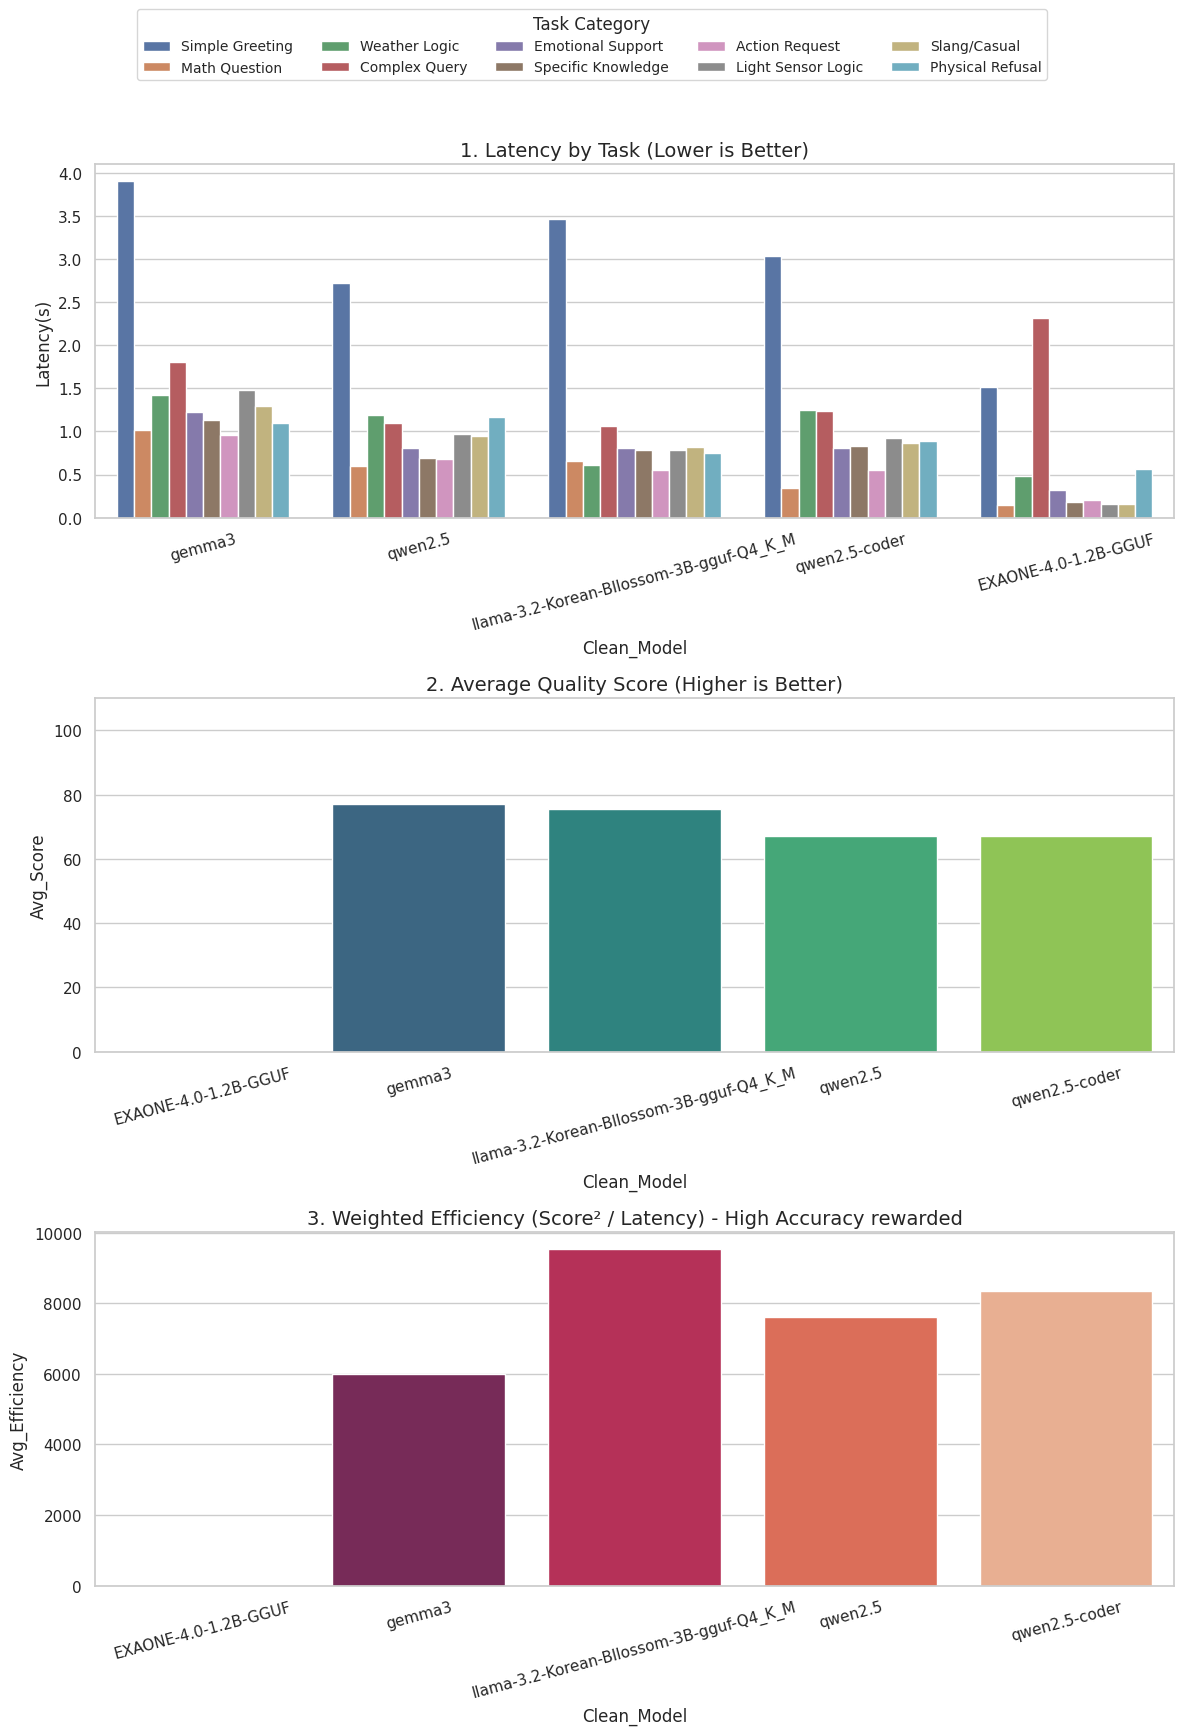

In [7]:
# ==========================================
# 6. Analysis & Visualization (Efficiency = Score^2 / Latency)
# ==========================================

df_data = [
    {
        "Model": r.model_name,
        "Category": r.category,
        "Latency(s)": r.latency,
        "Score": r.score,
        "Is_JSON": r.response.raw_json
    }
    for r in results
]
df = pd.DataFrame(df_data)

# [NEW] Weighted Efficiency Calculation
# 점수에 제곱을 하여 정확도의 중요성을 비선형적으로 높임. 
# 예: 100점 2초(5000) vs 50점 1초(2500) -> 정확한 게 훨씬 유리
df['Efficiency'] = df.apply(lambda row: (row['Score'] ** 2) / row['Latency(s)'] if row['Latency(s)'] > 0 else 0, axis=1)

def clean_model_name(name):
    name = name.replace("hf.co/", "")
    if ":" in name:
        name = name.split(":")[0] 
    if "/" in name:
        name = name.split("/")[-1] 
    return name

df["Clean_Model"] = df["Model"].apply(clean_model_name)

summary = df.groupby("Clean_Model").agg(
    Avg_Score=("Score", "mean"),
    Avg_Latency=("Latency(s)", "mean"),
    JSON_Rate=("Is_JSON", "mean"),
    Avg_Efficiency=("Efficiency", "mean") 
).reset_index()

print("=== 📊 종합 결과 요약 ===")
display(summary)

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

sns.barplot(data=df, x="Clean_Model", y="Latency(s)", hue="Category", ax=axes[0])
axes[0].set_title("1. Latency by Task (Lower is Better)", fontsize=14)
axes[0].tick_params(axis='x', rotation=15)
axes[0].get_legend().remove()

sns.barplot(data=summary, x="Clean_Model", y="Avg_Score", hue="Clean_Model", palette="viridis", legend=False, ax=axes[1])
axes[1].set_title("2. Average Quality Score (Higher is Better)", fontsize=14)
axes[1].set_ylim(0, 110)
axes[1].tick_params(axis='x', rotation=15)

sns.barplot(data=summary, x="Clean_Model", y="Avg_Efficiency", hue="Clean_Model", palette="rocket", legend=False, ax=axes[2])
axes[2].set_title("3. Weighted Efficiency (Score² / Latency) - High Accuracy rewarded", fontsize=14)
axes[2].tick_params(axis='x', rotation=15)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, 
           loc='lower center', 
           bbox_to_anchor=(0.5, 0.92), 
           ncol=5, 
           title="Task Category",
           fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.90]) 
plt.show()